In [1]:
import nnabla as nn

import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.monitor import tile_images

import numpy as np
import matplotlib.pyplot as plt
import tiny_digits
%matplotlib inline

np.random.seed(0)
imshow_opt = dict(cmap='gray', interpolation='nearest')

2023-02-14 13:12:52,622 [nnabla][INFO]: Initializing CPU extension...


Num images: 1797
Image shape: (8, 8)
Labels: [0 1 2 3 4 5 6 7 8 9]


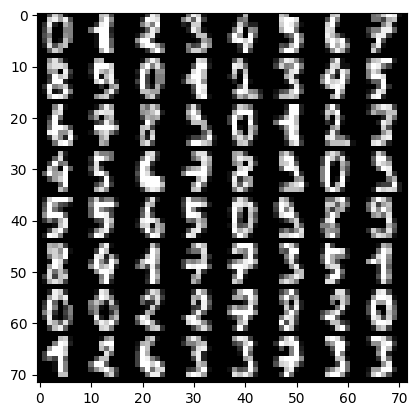

In [2]:
digits = tiny_digits.load_digits(n_class=10)
tiny_digits.plot_stats(digits)

In [3]:
data = tiny_digits.data_iterator_tiny_digits(digits, batch_size=64, shuffle=True)

2023-02-14 13:12:58,266 [nnabla][INFO]: DataSource with shuffle(True)
2023-02-14 13:12:58,277 [nnabla][INFO]: Using DataIterator


labels: [[5 9 7 4 5 7 0 8]
 [1 6 1 7 4 5 8 8]
 [3 3 1 7 1 6 7 9]
 [7 1 3 6 3 6 6 3]
 [7 8 0 1 5 5 4 6]
 [0 5 5 0 8 9 7 8]
 [3 9 8 5 9 7 4 6]
 [8 2 7 6 7 2 3 6]]
Label shape: (64, 1)


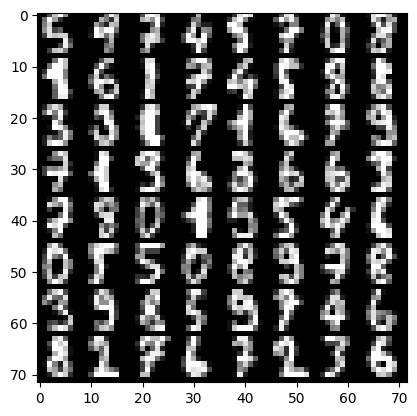

In [4]:
img, label = data.next()
plt.imshow(tile_images(img), **imshow_opt)
print("labels: {}".format(label.reshape(8, 8)))
print("Label shape: {}".format(label.shape))

In [5]:
# Forward pass
x = nn.Variable(img.shape)  # Define an image variable
with nn.parameter_scope("affine1"):
    y = PF.affine(x, 10)  # Output is 10 class

In [7]:
# Building a loss graph
t = nn.Variable(label.shape)  # Define an target variable
loss = F.mean(F.softmax_cross_entropy(y, t))  # Softmax Xentropy fits multi-class classification problems

In [8]:
print("Printing shapes of variables")
print(x.shape)
print(y.shape)
print(t.shape)
print(loss.shape)  # empty tuple means scalar

Printing shapes of variables
(64, 1, 8, 8)
(64, 10)
(64, 1)
()


In [9]:
# Set data
x.d = img
t.d = label
# Execute a forward pass
loss.forward()
# Showing results
print("Prediction score of 0-th image: {}".format(y.d[0]))
print("Loss: {}".format(loss.d))

Prediction score of 0-th image: [ 11.456303   -14.80989      0.62990785   1.8351557   -8.670639
   5.52641     12.154707     4.386307    -1.7381556    4.3205767 ]
Loss: 15.544096946716309


In [11]:
print(x.d.shape)

(64, 1, 8, 8)


In [10]:
print(nn.get_parameters())

OrderedDict([('affine1/affine/W', <Variable((64, 10), need_grad=True) at 0x7efdbaaccf90>), ('affine1/affine/b', <Variable((10,), need_grad=True) at 0x7efdb89d7fb0>)])


In [11]:
for param in nn.get_parameters().values():
    param.grad.zero()

In [12]:
# Compute backward
loss.backward()
# Showing gradients.
for name, param in nn.get_parameters().items():
    print(name, param.shape, param.g.flat[:20])  # Showing first 20.

affine1/affine/W (64, 10) [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  3.1451762e-01  2.2530122e-04
 -4.6851587e-02 -6.0762573e-02  6.3644449e-04 -2.0253170e-01
  8.7928891e-02 -4.6494704e-02 -1.5426296e-02 -3.1241389e-02]
affine1/affine/b (10,) [ 0.03753503 -0.09367488 -0.03121927 -0.06802998 -0.06231093  0.61294395
 -0.0296303  -0.17176978 -0.11591194 -0.0779319 ]


In [13]:
# Create a solver (gradient-based optimizer)
learning_rate = 1e-3
solver = S.Sgd(learning_rate)
solver.set_parameters(nn.get_parameters())  # Set parameter variables to be updated.

In [14]:
# One step of training
x.d, t.d = data.next()
loss.forward()
solver.zero_grad()  # Initialize gradients of all parameters to zero.
loss.backward()
solver.weight_decay(1e-5)  # Applying weight decay as an regularization
solver.update()
print(loss.d)

15.457939


In [15]:
for i in range(1000):
    x.d, t.d = data.next()
    loss.forward()
    solver.zero_grad()  # Initialize gradients of all parameters to zero.
    loss.backward()
    solver.weight_decay(1e-5)  # Applying weight decay as an regularization
    solver.update()
    if i % 100 == 0:  # Print for each 10 iterations
        print(i, loss.d)

0 14.856289
100 3.3033142
200 1.6482836
300 0.9386952
400 0.81573427
500 0.61047316
600 0.85099435
700 0.5396633
800 0.8011299
900 0.33507103


prediction:
[[7 5 0 0 1 2 3 2]
 [1 1 6 9 4 8 1 8]
 [0 4 5 8 2 1 0 9]
 [6 1 3 3 5 7 0 3]
 [8 4 2 0 9 7 7 7]
 [2 2 4 1 7 3 2 5]
 [8 9 2 7 1 9 5 2]
 [9 4 9 2 5 3 5 4]]


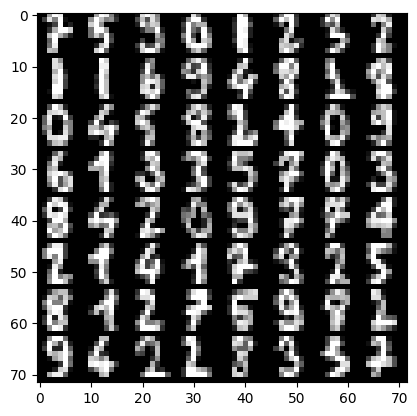

In [16]:
x.d, t.d = data.next()  # Here we predict images from training set although it's useless.
y.forward()  # You can execute a sub graph.
plt.imshow(tile_images(x.d), **imshow_opt)
print("prediction:")
print(y.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.

In [17]:
nn.clear_parameters()  # Clear all parameters

In [18]:
def mlp(x, hidden=[16, 32, 16]):
    hs = []
    with nn.parameter_scope("mlp"):  # Parameter scope can be nested
        h = x
        for hid, hsize in enumerate(hidden):
            with nn.parameter_scope("affine{}".format(hid + 1)):
                h = F.tanh(PF.affine(h, hsize))
                hs.append(h)
        with nn.parameter_scope("classifier"):
            y = PF.affine(h, 10)
    return y, hs

In [19]:
# Construct a MLP graph
y, hs = mlp(x)

In [20]:
print("Printing shapes")
print("x: {}".format(x.shape))
for i, h in enumerate(hs):
    print("h{}:".format(i + 1), h.shape)
print("y: {}".format(y.shape))

Printing shapes
x: (64, 1, 8, 8)
h1: (64, 16)
h2: (64, 32)
h3: (64, 16)
y: (64, 10)


In [22]:
def logreg_forward(x):
    with nn.parameter_scope("affine1"):
        y = PF.affine(x, 10)
    return y

def logreg_loss(y, t):
    loss = F.mean(F.softmax_cross_entropy(y, t))  # Softmax Xentropy fits multi-class classification problems
    return loss

In [23]:
# Training
loss = logreg_loss(y, t)  # Reuse logreg loss function.

# Copied from the above logreg example.
def training(steps, learning_rate):
    solver = S.Sgd(learning_rate)
    solver.set_parameters(nn.get_parameters())  # Set parameter variables to be updated.
    for i in range(steps):
        x.d, t.d = data.next()
        loss.forward()
        solver.zero_grad()  # Initialize gradients of all parameters to zero.
        loss.backward()
        solver.weight_decay(1e-5)  # Applying weight decay as an regularization
        solver.update()
        if i % 100 == 0:  # Print for each 10 iterations
            print(i, loss.d)


# Training
training(1000, 1e-2)

0 2.40488
100 1.8159349
200 1.563611
300 1.277965
400 1.0163379
500 0.884112
600 0.82765293
700 0.70395154
800 0.77710867
900 0.51379263


prediction:
[[5 6 2 5 1 3 7 5]
 [2 4 7 7 2 1 2 8]
 [3 1 5 6 7 8 6 5]
 [7 4 1 3 9 3 9 3]
 [9 5 6 8 9 6 5 8]
 [6 3 5 5 0 6 4 7]
 [5 9 9 6 6 1 5 2]
 [4 8 5 2 9 2 2 6]]


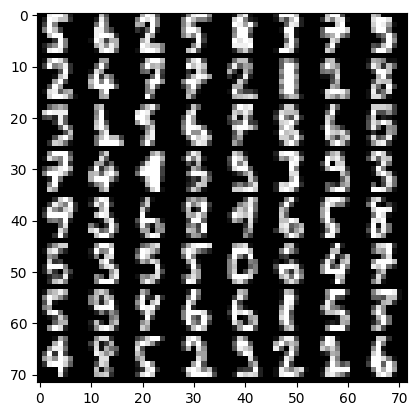

In [24]:
x.d, t.d = data.next()  # Here we predict images from training set although it's useless.
y.forward()  # You can execute a sub graph.
plt.imshow(tile_images(x.d), **imshow_opt)
print("prediction:")
print(y.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.